# Final Project: Predicting Olympic medal wins by Team

original dataset from: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

In [120]:
# Imports

from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics

In [264]:
# Files

# DATASET
df_athlete_events = pd.read_csv('data/Athlete_Info/athlete_events.csv')

# REGIONS
df_noc_regions = pd.read_csv('data/Athlete_Info/noc_regions.csv')

# POPULATION
df_world_pop = pd.read_csv('data/WorldPopulation.csv')
print(len(df_world_pop))
# drop unwanted columns 
df_world_pop = df_world_pop.drop(["Indicator Name","Indicator Code","Unnamed: 61"],axis=1)
# Pivot population table
df_world_pop = df_world_pop.melt(id_vars=["Country", "Country Code"], 
        var_name="Year", 
        value_name="Population")
df_world_pop['Year']=df_world_pop['Year'].astype(int)



217


##### Original dataset:
271,116 rows and 15 columns

In [265]:
# Clean the data

# Note: Columns w/ NaNs: Age, Weight, Height, Medal

# replace NaNs in Medal with "Did not win"
df_athlete_events['Medal'].fillna('DNW', inplace = True)
df_athlete_events.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW


In [266]:
# NOC is incorrect, it associates NOCs with more than it should (ie FRA should not be 160)
print(df_athlete_events.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64


In [267]:
# merge olympic data with df_noc_regions
olympics_merge = df_athlete_events.merge(df_noc_regions,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')
olympics_merge.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NaN


In [268]:
# more cleaning, replace missing teams 
olympics_merge['region'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['region'])
olympics_merge['region'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['region'])
olympics_merge['region'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['region'])
olympics_merge['region'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['region'])


In [269]:
# get values from country and put into team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'region': 'Team'}, inplace = True)

In [270]:
# check again, looks better!
print(olympics_merge.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

GRE    1
SRI    1
CAY    1
PLW    1
CIV    1
Name: NOC, dtype: int64


In [271]:
# Serbia has missing population data, fill in manually (not the best method, but will do)
conditions = [
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1964),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1968),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1972),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1976),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1980),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1984),
    (df_world_pop['Country'] == 'Serbia') & (df_world_pop['Year'] == 1988)]
choices = [7800000,8000000,8300000,8600000,8900000,9200000,9400000]
df_world_pop['Population'] = np.select(conditions, choices, df_world_pop['Population'])

In [272]:
# update NOCs, many NOCs in population dataset is not the same as the NOC in the olympic dataset

olympics_merge.loc[olympics_merge.Team == "Netherlands", ['NOC']] =  'NLD'
olympics_merge.loc[olympics_merge.Team == "Greece", ['NOC']] =  'GRC'
olympics_merge.loc[olympics_merge.Team == "Aruba", ['NOC']] =  'ABW'
olympics_merge.loc[olympics_merge.Team == "Bulgaria", ['NOC']] =  'BGR'
olympics_merge.loc[olympics_merge.Team == "Sudan", ['NOC']] =  'SDN'

olympics_merge.loc[olympics_merge.Team == "Malawi", ['NOC']] =  'MWI'
olympics_merge.loc[olympics_merge.Team == "Fiji", ['NOC']] =  'FJI'
olympics_merge.loc[olympics_merge.Team == "Myanmar", ['NOC']] =  'MMR'
olympics_merge.loc[olympics_merge.Team == "Chad", ['NOC']] =  'TCD'
olympics_merge.loc[olympics_merge.Team == "Nicaragua", ['NOC']] =  'NIC'
olympics_merge.loc[olympics_merge.Team == "Nigeria", ['NOC']] =  'NGA'
olympics_merge.loc[olympics_merge.Team == "Nepal", ['NOC']] =  'NPL'
olympics_merge.loc[olympics_merge.Team == "Madagascar", ['NOC']] =  'MDG'
olympics_merge.loc[olympics_merge.Team == "Kuwait", ['NOC']] =  'KWT'
olympics_merge.loc[olympics_merge.Team == "Algeria", ['NOC']] =  'DZA'
olympics_merge.loc[olympics_merge.Team == "Lebanon", ['NOC']] =  'LBN'
olympics_merge.loc[olympics_merge.Team == "Iran", ['NOC']] =  'IRN'
olympics_merge.loc[olympics_merge.Team == "South Africa", ['NOC']] =  'ZAF'
olympics_merge.loc[olympics_merge.Team == "Malaysia", ['NOC']] =  'MYS'
olympics_merge.loc[olympics_merge.Team == "Eritrea", ['NOC']] =  'ERI'
olympics_merge.loc[olympics_merge.Team == "Tanzania", ['NOC']] =  'TZA'
olympics_merge.loc[olympics_merge.Team == "Palestine", ['NOC']] =  'PSE'
olympics_merge.loc[olympics_merge.Team == "Libya", ['NOC']] =  'LBY'
olympics_merge.loc[olympics_merge.Team == "Brunei", ['NOC']] =  'BRN'
olympics_merge.loc[olympics_merge.Team == "Saudi Arabia", ['NOC']] =  'SAU'
olympics_merge.loc[olympics_merge.Team == "United Arab Emirates", ['NOC']] =  'ARE'

olympics_merge.loc[olympics_merge.Team == "Yemen", ['NOC']] =  'YEM'
olympics_merge.loc[olympics_merge.Team == "Indonesia", ['NOC']] =  'IDN'
olympics_merge.loc[olympics_merge.Team == "Philippines", ['NOC']] =  'PHL'
olympics_merge.loc[olympics_merge.Team == "Republic of Congo", ['NOC']] =  'COD'
olympics_merge.loc[olympics_merge.Team == "Sri Lanka", ['NOC']] =  'LKA'
olympics_merge.loc[olympics_merge.Team == "Niger", ['NOC']] =  'NER'
olympics_merge.loc[olympics_merge.Team == "Switzerland", ['NOC']] =  'CHE'
olympics_merge.loc[olympics_merge.Team == "Costa Rica", ['NOC']] =  'CRI'
olympics_merge.loc[olympics_merge.Team == "Slovenia", ['NOC']] =  'SVN'
olympics_merge.loc[olympics_merge.Team == "Portugal", ['NOC']] =  'PRT'
olympics_merge.loc[olympics_merge.Team == "Paraguay", ['NOC']] =  'PRY'
olympics_merge.loc[olympics_merge.Team == "Angola", ['NOC']] =  'AGO'
olympics_merge.loc[olympics_merge.Team == "Bangladesh", ['NOC']] =  'BGD'
olympics_merge.loc[olympics_merge.Team == "Uruguay", ['NOC']] =  'URY'
olympics_merge.loc[olympics_merge.Team == "El Salvador", ['NOC']] =  'SLV'
olympics_merge.loc[olympics_merge.Team == "Puerto Rico", ['NOC']] =  'PRI'
olympics_merge.loc[olympics_merge.Team == "Honduras", ['NOC']] =  'HND'

olympics_merge.loc[olympics_merge.Team == "Mauritius", ['NOC']] =  'MUS'
olympics_merge.loc[olympics_merge.Team == "Seychelles", ['NOC']] =  'SYC'
olympics_merge.loc[olympics_merge.Team == "Czech Republic", ['NOC']] =  'CZE'
olympics_merge.loc[olympics_merge.Team == "Mauritania", ['NOC']] =  'MRT'
olympics_merge.loc[olympics_merge.Team == "Saint Kitts", ['NOC']] =  'KNA'
olympics_merge.loc[olympics_merge.Team == "Saint Vincent", ['NOC']] =  'VCT'
olympics_merge.loc[olympics_merge.Team == "Mongolia", ['NOC']] =  'MNG'
olympics_merge.loc[olympics_merge.Team == "Monaco", ['NOC']] =  'MCO'
olympics_merge.loc[olympics_merge.Team == "Togo", ['NOC']] =  'TGO'
olympics_merge.loc[olympics_merge.Team == "American Samoa", ['NOC']] =  'ASM'
olympics_merge.loc[olympics_merge.Team == "Samoa", ['NOC']] =  'WSM'
olympics_merge.loc[olympics_merge.Team == "Croatia", ['NOC']] =  'HRV'
olympics_merge.loc[olympics_merge.Team == "Haiti", ['NOC']] =  'HTI'
olympics_merge.loc[olympics_merge.Team == "Denmark", ['NOC']] =  'DNK'
olympics_merge.loc[olympics_merge.Team == "Guinea", ['NOC']] =  'GIN'
olympics_merge.loc[olympics_merge.Team == "Belize", ['NOC']] =  'BLZ'
olympics_merge.loc[olympics_merge.Team == "Bermuda", ['NOC']] =  'BMU'
olympics_merge.loc[olympics_merge.Team == "Serbia", ['NOC']] =  'SRB'
olympics_merge.loc[olympics_merge.Team == "Curaco", ['NOC']] =  'CUW'

olympics_merge.loc[olympics_merge.Team == "Oman", ['NOC']] =  'OMN'
olympics_merge.loc[olympics_merge.Team == "Vanuatu", ['NOC']] =  'VUT'
olympics_merge.loc[olympics_merge.Team == "Bahamas", ['NOC']] =  'BHS'
olympics_merge.loc[olympics_merge.Team == "Guatemala", ['NOC']] =  'GTM'
olympics_merge.loc[olympics_merge.Team == "Latvia", ['NOC']] =  'LVA'
olympics_merge.loc[olympics_merge.Team == "Virgin Islands, British", ['NOC']] =  'VGB'
olympics_merge.loc[olympics_merge.Team == "Virgin Islands, US", ['NOC']] =  'VIR'
olympics_merge.loc[olympics_merge.Team == "Cayman Islands", ['NOC']] =  'CYM'
olympics_merge.loc[olympics_merge.Team == "Barbados", ['NOC']] =  'BRB'
olympics_merge.loc[olympics_merge.Team == "Guinea-Bissau", ['NOC']] =  'GNB'
olympics_merge.loc[olympics_merge.Team == "Botswana", ['NOC']] =  'BWA'
olympics_merge.loc[olympics_merge.Team == "Cambodia", ['NOC']] =  'KHM'
olympics_merge.loc[olympics_merge.Team == "Solomon Islands", ['NOC']] =  'SLB'
olympics_merge.loc[olympics_merge.Team == "Equatorial Guinea", ['NOC']] =  'GNQ'
olympics_merge.loc[olympics_merge.Team == "Antigua", ['NOC']] =  'ATG'
olympics_merge.loc[olympics_merge.Team == "Zimbabwe", ['NOC']] =  'ZWE'
olympics_merge.loc[olympics_merge.Team == "Grenada", ['NOC']] =  'GRD'
olympics_merge.loc[olympics_merge.Team == "Zambia", ['NOC']] =  'ZMB'
olympics_merge.loc[olympics_merge.Team == "Taiwan", ['NOC']] =  'TWN'
olympics_merge.loc[olympics_merge.Team == "Gambia", ['NOC']] =  'GMB'
olympics_merge.loc[olympics_merge.Team == "Cook Islands", ['NOC']] =  'COK'
olympics_merge.loc[olympics_merge.Team == "Burkina Faso", ['NOC']] =  'BFA'
olympics_merge.loc[olympics_merge.Team == "Bhutan", ['NOC']] =  'BTN'
olympics_merge.loc[olympics_merge.Team == "Tonga", ['NOC']] =  'TON'
olympics_merge.loc[olympics_merge.Team == "Lesotho", ['NOC']] =  'LSO'
olympics_merge.loc[olympics_merge.Team == "Eritrea", ['NOC']] =  'ERI'

olympics_merge.loc[olympics_merge.Team == "Vietnam", ['NOC']] =  'VNM'
olympics_merge.loc[olympics_merge.Team == "Kosovo", ['NOC']] =  'XKX'
olympics_merge.loc[olympics_merge.Team == "Curacao", ['NOC']] =  'CUW'

olympics_merge.loc[olympics_merge.Team == "Russia", ['NOC']] =  'RUS'
olympics_merge.loc[olympics_merge.Team == "Germany", ['NOC']] =  'DEU'

In [273]:
# merge together olympic dataset + population dataset on country code (NOC) and year
df_olympics = olympics_merge.merge(df_world_pop, left_on = ["NOC","Year"], right_on = ["Country Code","Year"], how = 'left')

len(df_olympics)

271116

In [274]:
# data 1961 onwards only, when population data begins
olympics_complete_subset = df_olympics.loc[(df_olympics['Year'] > 1960), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

In [275]:
# create column to state if won medal (1) or not (0)
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

In [276]:
# figure out which events are team events, only want to count these medals once
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

In [277]:
# some sports had multiple golds, remove these
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar", 
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

In [278]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# filter for medal_won (1)
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# if medal is won and event in team event list then team_event=1
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# if medal is won and event not in team event list then singles_event=1
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# identify team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

In [279]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [280]:

medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        1604.0
Russia     1601.0
Germany    1393.0
China       598.0
Name: All, dtype: float64

Text(0.5, 1.0, 'Olympic Performance Comparison')

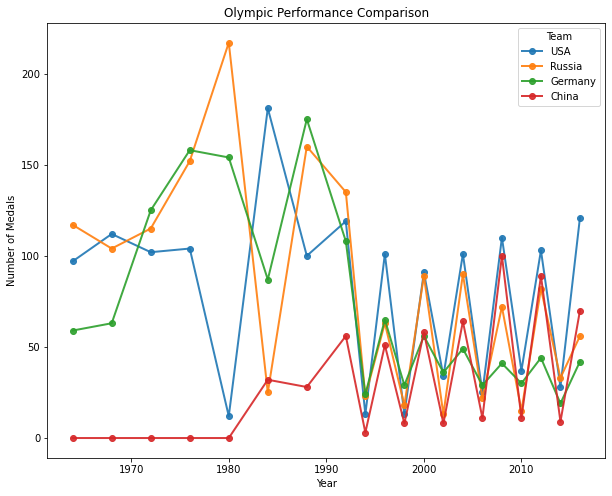

In [281]:
# plot medals by top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plot
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
plt.ylabel('Number of Medals')
plt.title('Olympic Performance Comparison')

Text(0.5, 1.0, 'Medal Breakdown by Top Teams')

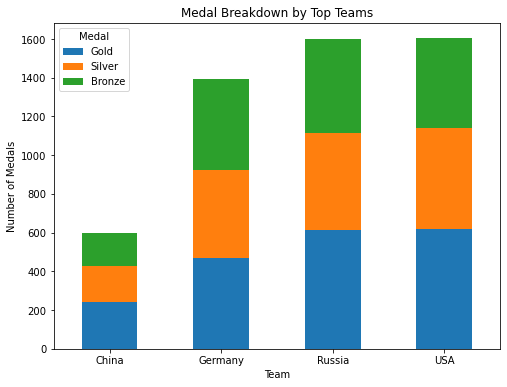

In [282]:
# plot type of medals by top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table, calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
plt.ylabel('Number of Medals')
plt.title('Medal Breakdown by Top Teams')

In [283]:
# athletes in more than one sport if duplicates in year/team/name, drop those

row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)
year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()
year_team_gender

,Year,Team,Name,Sex
0,1992,China,A Dijiang,M
1,2012,China,A Lamusi,M
8,1992,USA,Per Knut Aaland,M
12,1994,USA,Per Knut Aaland,M
16,1992,USA,John Aalberg,M
...,...,...,...,...
199824,2004,Russia,Olesya Nikolayevna Zykina,F
199825,2002,Russia,Yevgeny Aleksandrovich Zykov,M
199828,1972,USA,"James Francis ""Jim"" Zylker",M
199829,2000,Russia,Aleksandr Viktorovich Zyuzin,M


In [284]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns 
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [285]:
# Separate data by team

chi_data = year_team_gender_count[year_team_gender_count['Team'] == "China"]
chi_data.fillna(0, inplace = True)
chi_data.set_index('Year', inplace = True)

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


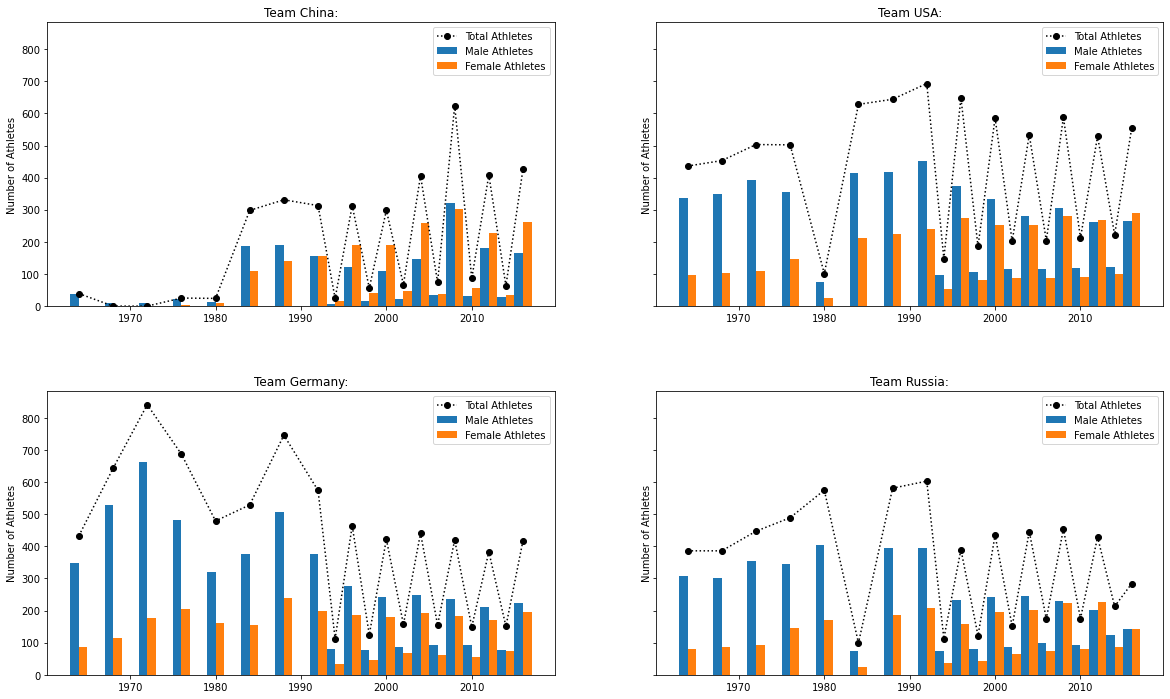

In [286]:
# Plot the values of male/female/total athletes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12), sharey = True)
fig.subplots_adjust(hspace = 0.3)

# China
ax1.bar(chi_data.index.values, chi_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax1.bar(chi_data.index.values, chi_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax1.plot(chi_data.index.values, chi_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax1.set_title('Team China:')
ax1.set_ylabel('Number of Athletes')
ax1.legend(loc = 'best')

# USA
ax2.bar(usa_data.index.values, usa_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax2.bar(usa_data.index.values, usa_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax2.plot(usa_data.index.values, usa_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax2.set_title('Team USA:')
ax2.set_ylabel('Number of Athletes')
ax2.legend(loc = 'best')

# Germany
ax3.bar(ger_data.index.values, ger_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax3.bar(ger_data.index.values, ger_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax3.plot(ger_data.index.values, ger_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes', 
         marker = 'o')
ax3.set_title('Team Germany:')
ax3.set_ylabel('Number of Athletes')
ax3.legend(loc = 'best')

# Russia
ax4.bar(rus_data.index.values, rus_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax4.bar(rus_data.index.values, rus_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax4.plot(rus_data.index.values, rus_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax4.set_title('Team Russia:')
ax4.set_ylabel('Number of Athletes')
ax4.legend(loc = 'best')


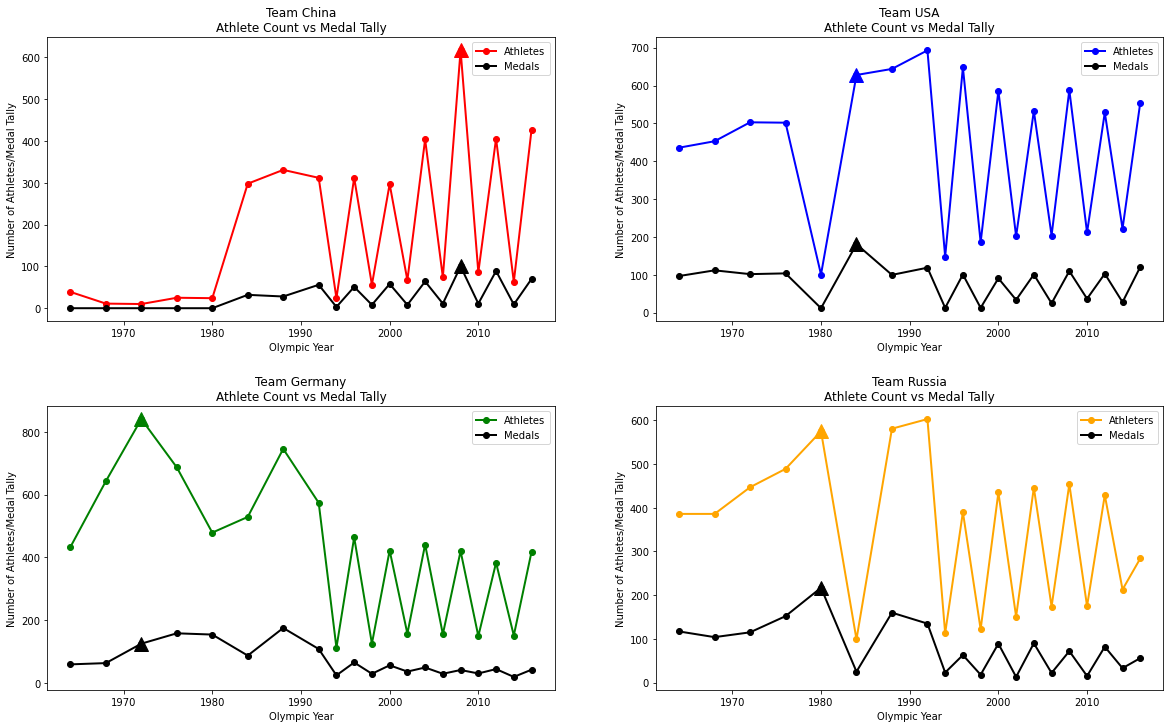

In [287]:
# Athletes by year
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2,
                                         ncols = 2,
                                        figsize = (20,12))

fig.subplots_adjust(hspace = 0.3)

# China
contingent_size['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'red', 
                                  label = 'Athletes')
year_team_medals['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = 'Medals')
ax1.plot(2008, contingent_size.loc[2008, 'China'], marker = '^', color = 'red', ms = 14)
ax1.plot(2008, year_team_medals.loc[2008, 'China'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes/Medal Tally')
ax1.set_title('Team China\nAthlete Count vs Medal Tally')
ax1.legend(loc = 'best')

# USA
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = 'Athletes')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medals')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'blue', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Athletes/Medal Tally')
ax2.set_title('Team USA\nAthlete Count vs Medal Tally')
ax2.legend(loc = 'best')

# Germany
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                               label = 'Athletes')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = 'Medals')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'green', ms = 14)
ax3.set_xlabel('Olympic Year')
ax3.set_ylabel('Number of Athletes/Medal Tally')
ax3.set_title('Team Germany\nAthlete Count vs Medal Tally')
ax3.legend(loc = 'best')

# Russia
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                              label = 'Athleters')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = 'Medals')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'orange', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('Olympic Year')
ax4.set_ylabel('Number of Athletes/Medal Tally')
ax4.set_title('Team Russia\nAthlete Count vs Medal Tally')
ax4.legend(loc = 'best')


In [288]:
# aggregate the medal_tally_agnostic dataframe to find what sports each team is best at
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'DNW'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']

best_team_sports.groupby('Team').head(5)

# merge best team sports with olympics data to get sport for each event
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the similarities
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,China,Germany,Russia,USA,All
Sport,,,,,
Luge,0,3,0,0,3
Athletics,0,0,0,2,2
Diving,2,0,0,0,2
Swimming,0,0,0,2,2
Badminton,1,0,0,0,1
Basketball,0,0,0,1,1
Biathlon,0,0,1,0,1
Canoeing,0,1,0,0,1
Equestrianism,0,1,0,0,1


Note, each team may have own "best". In other words, that may be a reason they are top winners... They are not competing against each other as often

In [289]:
# lets create a data frame of athletes with the sport they participated in and the number of medals won.
ath_sport_medal = olympics_complete_subset.groupby(['Team','Name', 'Sport'])['Medal_Won'].agg('sum').reset_index()
ath_sport_medal.sort_values(['Sport', 'Medal_Won'], ascending = [True, False], inplace = True)

# keep only athletes who won medals
medal_mask = ath_sport_medal['Medal_Won'] > 0
ath_sport_medal = ath_sport_medal[medal_mask]


# Now lets calculate the number of participations of each athlete. This will be sport wise.
ath_sport_appearance = olympics_complete_subset.groupby(['Team', 'Name', 'Sport'])['NOC'].agg('count').reset_index()

ath_sport_appearance.rename(columns = {'NOC': 'Event_Count'}, inplace = True)

ath_sport_appearance.head()

# lets merge these two.
ath_medal_appearance = ath_sport_medal.merge(ath_sport_appearance,
                                            left_on = ["Team", "Name", "Sport"],
                                            right_on = ['Team', 'Name', 'Sport'],
                                            how = "left")

# Calculate the medal per participation
ath_medal_appearance['Medal_Per_Participation'] = ath_medal_appearance['Medal_Won']/ath_medal_appearance['Event_Count']

ath_medal_appearance.sort_values(['Medal_Per_Participation', 'Medal_Won'], ascending = [False, False], inplace = True)

ath_medal_appearance.head(10)


# filter out athletes with less than 10 total medals.
ath_medal_appearance = ath_medal_appearance[ath_medal_appearance['Medal_Won'] >= 10]

ath_medal_appearance

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
15099,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.000000
356,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.000000
5920,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.000000
15104,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.000000
15096,USA,"Michael Fred Phelps, II",Swimming,28,30,0.933333
4201,Germany,Birgit Fischer-Schmidt,Canoeing,12,13,0.923077
15097,USA,"Dara Grace Torres (-Hoffman, -Minas)",Swimming,12,13,0.923077
15101,USA,Mark Andrew Spitz,Swimming,11,12,0.916667
15102,USA,"Matthew Nicholas ""Matt"" Biondi",Swimming,11,12,0.916667
15100,USA,Ryan Steven Lochte,Swimming,12,14,0.857143


In [290]:
# create the year, team contingent size
year_team_gender = olympics_complete_subset.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes','Female_Athletes','Male_Athletes']]
year_team_contingent.head()

,Year,Team,Total_Athletes,Female_Athletes,Male_Athletes
0,1964,Afghanistan,8.0,0.0,8.0
1,1964,Algeria,1.0,0.0,1.0
2,1964,Argentina,114.0,7.0,107.0
3,1964,Australia,248.0,42.0,206.0
4,1964,Austria,139.0,25.0,114.0


In [291]:
# Get year team population
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population','Season','Sport']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population,Season,Sport
0,1992,China,1.164970e+09,Summer,Basketball
1,2012,China,1.350695e+09,Summer,Judo
2,1988,Netherlands,1.476009e+07,Winter,Speed Skating
4,1992,Netherlands,1.518417e+07,Winter,Speed Skating
6,1994,Netherlands,1.538284e+07,Winter,Speed Skating


In [292]:
# merge all these datasets together

medal_pop_contingent = year_team_pop.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')

medal_pop_contingent = medal_pop_contingent.merge(medal_tally,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')

medal_pop_contingent.head()

,Year,Team,Population,Season,Sport,Total_Athletes,Female_Athletes,Male_Athletes,Medal_Won_Corrected
0,1992,China,1.164970e+09,Summer,Basketball,313.0,156.0,157.0,56.0
1,2012,China,1.350695e+09,Summer,Judo,408.0,228.0,180.0,89.0
2,1988,Netherlands,1.476009e+07,Winter,Speed Skating,158.0,59.0,99.0,16.0
3,1992,Netherlands,1.518417e+07,Winter,Speed Skating,220.0,94.0,126.0,19.0
4,1994,Netherlands,1.538284e+07,Winter,Speed Skating,21.0,8.0,13.0,4.0


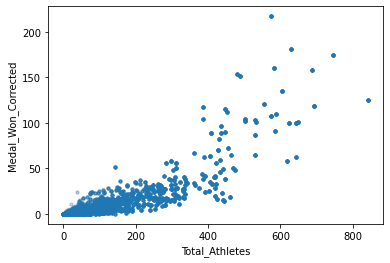

In [293]:
# Scatter: Continuous vs. Continuous
medal_pop_contingent.plot.scatter('Total_Athletes','Medal_Won_Corrected',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

In [294]:
# where are missing values
null_population = medal_pop_contingent[medal_pop_contingent["Population"].isnull()]
print(len(null_population))

241


In [152]:
# find out where nulls are
medal_pop_contingent.isnull().sum()

Year                     0
Team                     0
Population             241
Season                   0
Sport                    0
Total_Athletes           0
Female_Athletes          0
Male_Athletes            0
Medal_Won_Corrected      0
dtype: int64

In [153]:
# which teams have missing population values
medal_pop_contingent[medal_pop_contingent["Population"].isnull()].Team.unique()

array(['Eritrea', 'Kuwait', 'Individual Olympic Athletes',
       'Refugee Olympic Athletes', 'Taiwan', 'Cook Islands',
       'South Sudan'], dtype=object)

In [154]:
# how many medals are won by missing value rows
medal_pop_contingent[medal_pop_contingent["Population"].isnull()].Medal_Won_Corrected.sum()

377.0

In [157]:
# replace null with 0s 
medal_pop_contingent["Population"].fillna(0, inplace=True)

# remove rows with population = 0
medal_pop_contingent =medal_pop_contingent[medal_pop_contingent['Population'] !=0]
# reset index
medal_pop_contingent = medal_pop_contingent.reset_index()

In [177]:
# verify no more nulls
medal_pop_contingent.isnull().sum()

index                  0
Year                   0
Team                   0
Population             0
Season                 0
Sport                  0
Total_Athletes         0
Female_Athletes        0
Male_Athletes          0
Medal_Won_Corrected    0
dtype: int64

In [178]:
# final dataset for EDA and modeling
medal_pop_contingent

,index,Year,Team,Population,Season,Sport,Total_Athletes,Female_Athletes,Male_Athletes,Medal_Won_Corrected
0,0,1992,China,1.164970e+09,Summer,Basketball,313.0,156.0,157.0,56.0
1,1,2012,China,1.350695e+09,Summer,Judo,408.0,228.0,180.0,89.0
2,2,1988,Netherlands,1.476009e+07,Winter,Speed Skating,158.0,59.0,99.0,16.0
3,3,1992,Netherlands,1.518417e+07,Winter,Speed Skating,220.0,94.0,126.0,19.0
4,4,1994,Netherlands,1.538284e+07,Winter,Speed Skating,21.0,8.0,13.0,4.0
...,...,...,...,...,...,...,...,...,...,...
20794,21035,2004,Morocco,3.017928e+07,Summer,Weightlifting,55.0,8.0,47.0,3.0
20795,21036,2012,Croatia,4.267558e+06,Summer,Wrestling,107.0,43.0,64.0,6.0
20796,21037,1992,Latvia,2.614338e+06,Summer,Wrestling,57.0,13.0,44.0,3.0
20797,21038,2012,Chile,1.613580e+05,Summer,Judo,35.0,14.0,21.0,0.0


# More EDA

In [59]:
print(medal_pop_contingent.dtypes)

Year                     int64
Team                    object
Population             float64
Season                  object
Sport                   object
Total_Athletes         float64
Female_Athletes        float64
Male_Athletes          float64
Medal_Won_Corrected    float64
dtype: object


## Categorical Features
value_counts()


'Team','Year','Sport','Season'

In [60]:
print(medal_pop_contingent['Team'].value_counts())

USA            514
Germany        511
Russia         489
Japan          484
Italy          482
              ... 
Nauru            8
Saint Kitts      6
Timor-Leste      6
Tuvalu           5
Kosovo           5
Name: Team, Length: 202, dtype: int64


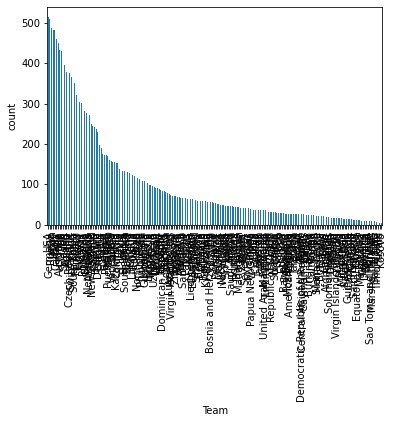

In [61]:
pd.value_counts(medal_pop_contingent['Team']).plot.bar()
plt.ylabel('count')
plt.xlabel('Team')
plt.show()

In [62]:
# Team
print(medal_pop_contingent['Team'].value_counts())

USA            514
Germany        511
Russia         489
Japan          484
Italy          482
              ... 
Nauru            8
Saint Kitts      6
Timor-Leste      6
Tuvalu           5
Kosovo           5
Name: Team, Length: 202, dtype: int64


In [63]:
# Year 
print(medal_pop_contingent['Year'].value_counts())

2016    1854
2012    1757
2008    1692
2004    1631
1992    1605
2000    1589
1996    1500
1988    1387
1984    1145
1972     999
1976     898
1968     861
1964     821
1980     777
2014     422
2010     417
2006     401
2002     390
1998     351
1994     302
Name: Year, dtype: int64


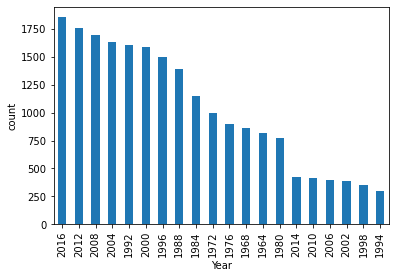

In [64]:
pd.value_counts(medal_pop_contingent['Year']).plot.bar()
plt.ylabel('count')
plt.xlabel('Year')
plt.show()

Summer    16972
Winter     3827
Name: Season, dtype: int64


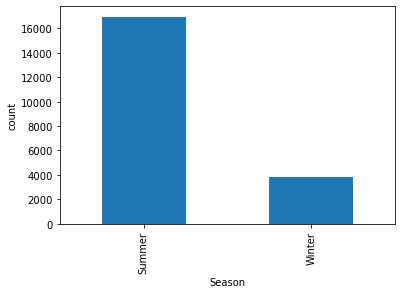

In [65]:
# Season
print(medal_pop_contingent['Season'].value_counts())
pd.value_counts(medal_pop_contingent['Season']).plot.bar()
plt.ylabel('count')
plt.xlabel('Season')
plt.show()

Athletics                    1997
Swimming                     1374
Shooting                     1097
Boxing                       1032
Judo                         1001
Weightlifting                 882
Cycling                       805
Wrestling                     767
Sailing                       756
Alpine Skiing                 632
Rowing                        589
Canoeing                      548
Fencing                       531
Cross Country Skiing          492
Archery                       476
Gymnastics                    474
Equestrianism                 423
Table Tennis                  399
Diving                        388
Tennis                        386
Biathlon                      354
Figure Skating                345
Modern Pentathlon             311
Speed Skating                 294
Taekwondo                     292
Badminton                     274
Bobsleigh                     271
Luge                          262
Football                      252
Ski Jumping   

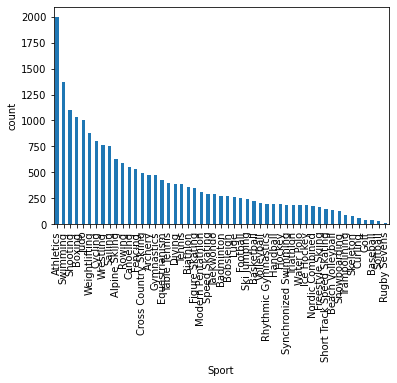

In [66]:
# Sport
print(medal_pop_contingent['Sport'].value_counts())
pd.value_counts(medal_pop_contingent['Sport']).plot.bar()
plt.ylabel('count')
plt.xlabel('Sport')
plt.show()

### Continuous Features
.describe()

count    2.079900e+04
mean     6.217098e+07
std      1.776581e+08
min      1.003300e+04
25%      5.228172e+06
50%      1.277751e+07
75%      5.192104e+07
max      1.378665e+09
Name: Population, dtype: float64


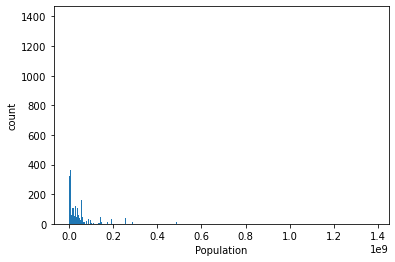

In [67]:
# Population
print(medal_pop_contingent['Population'].describe())
medal_pop_contingent['Population'].plot.hist(bins = medal_pop_contingent['Population'].nunique())
plt.xlabel('Population')
plt.ylabel('count')
plt.show()

## Visualizations

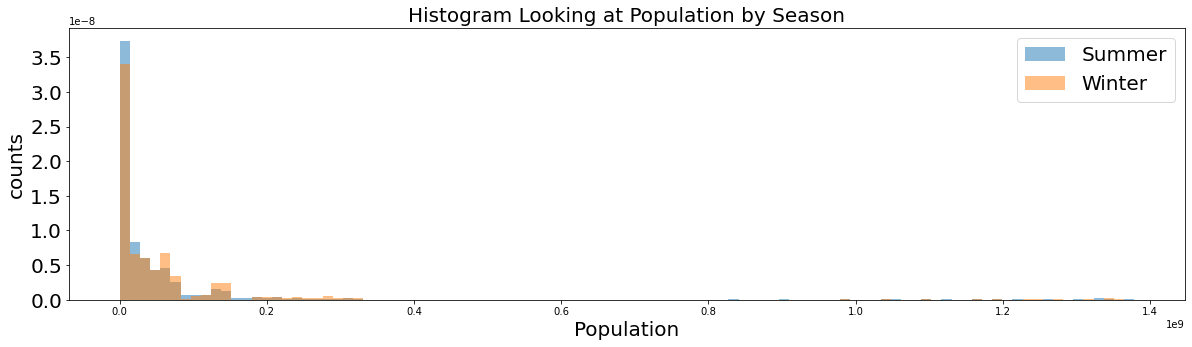

In [69]:
txt = ""

# Category specific histograms: continuous vs. categorical 
categories = medal_pop_contingent['Season'].unique()
bin_range = (medal_pop_contingent['Population'].min(),df_olympics['Population'].max())
for c in categories:
    plt.hist(medal_pop_contingent[medal_pop_contingent['Season']==c]['Population'],alpha=0.5,label=c,range=bin_range,bins=100,density=True)
plt.legend(fontsize= 20)
plt.yticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('counts',fontsize= 20)
plt.xlabel('Population',fontsize= 20)
plt.title("Histogram Looking at Population by Season", fontsize= 20)
fig = plt.gcf()
fig.text(.5, -0.1, txt, ha='center')
fig.set_size_inches(20, 5)
plt.show()

# Time Series Split

use TimeSeriesSplit since we want to use past data to predict

### Split the data

In [210]:
random_state = 18

groups = medal_pop_contingent[['Team']]  
y = medal_pop_contingent['Medal_Won_Corrected']            
X = medal_pop_contingent.drop(["Medal_Won_Corrected"], axis=1)

tscv = TimeSeriesSplit(n_splits = 3)
for train_index, test_index in tscv.split(X):
    X_train, X_other = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_other = y[train_index], y[test_index]
            
    # Split Other into Val and Test
    tscv2 = TimeSeriesSplit(n_splits = 3)
    for test_index, CV_index in tscv2.split(X_other,y_other):
        X_test, X_CV = X[:len(test_index)], X[len(test_index): (len(test_index)+len(CV_index))]
        y_test, y_CV = y[test_index], y[CV_index]

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(15600, 9)
(1299, 9)
(3900, 9)


### Transform the data

In [211]:
from sklearn.impute import SimpleImputer

cat_ftrs = ['Year','Sport','Season','Team'] #onehotencoder (ordinal, no rank)
num_ftrs = ['Population','Total_Athletes','Female_Athletes','Male_Athletes'] #standard (continuous, no boundary)

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

### Preprocess the data

In [212]:
X_prep = preprocessor.fit_transform(X_train)

# little hacky, but collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs)) + \
                preprocessor.transformers_[1][-1]

# fit and transform the train
df_train = pd.DataFrame(data=X_prep,columns=feature_names[:-4])
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names[:-4])
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names[:-4])
print(df_test.shape)

(15600, 279)
(1299, 279)
(3900, 279)


In [213]:
df_train.head(3)

,Population,Total_Athletes,Female_Athletes,Male_Athletes,Year_1964,Year_1968,Year_1972,Year_1976,Year_1980,Year_1984,...,Team_Uruguay,Team_Uzbekistan,Team_Vanuatu,Team_Venezuela,Team_Vietnam,"Team_Virgin Islands, British","Team_Virgin Islands, US",Team_Yemen,Team_Zambia,Team_Zimbabwe
0,6.083533,0.949812,1.566183,0.484565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.112227,1.541531,2.672238,0.705087,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287250,-0.015624,0.076081,-0.071536,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
df_CV.head(3)

,Population,Total_Athletes,Female_Athletes,Male_Athletes,Year_1964,Year_1968,Year_1972,Year_1976,Year_1980,Year_1984,...,Team_Uruguay,Team_Uzbekistan,Team_Vanuatu,Team_Venezuela,Team_Vietnam,"Team_Virgin Islands, British","Team_Virgin Islands, US",Team_Yemen,Team_Zambia,Team_Zimbabwe
0,-0.328992,-0.133968,-0.446223,0.072283,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.086350,1.628732,1.950230,1.289952,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088038,1.747076,2.103849,1.376243,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
df_test.head(3)

,Population,Total_Athletes,Female_Athletes,Male_Athletes,Year_1964,Year_1968,Year_1972,Year_1976,Year_1980,Year_1984,...,Team_Uruguay,Team_Uzbekistan,Team_Vanuatu,Team_Venezuela,Team_Vietnam,"Team_Virgin Islands, British","Team_Virgin Islands, US",Team_Yemen,Team_Zambia,Team_Zimbabwe
0,6.083533,0.949812,1.566183,0.484565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.112227,1.541531,2.672238,0.705087,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.287250,-0.015624,0.076081,-0.071536,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Methods

## Choose one or more ML techniques
## Tune the hyperparameters of your ML models (aka cross-validation)
## Interpret your model

#### Lasso (Regularization)

In [252]:
from  sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alpha= [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
thetas = []
models = []
train_MSE = np.zeros(len(alpha))
val_MSE = np.zeros(len(alpha))

# do the fit
for i in range(len(alpha)):
    # load the linear regression model
    lin_reg = Lasso(alpha=alpha[i],max_iter=100000000)
    lin_reg.fit(df_train, y_train)
    thetas.append(lin_reg.coef_)
    models.append(lin_reg)
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(df_train))
    val_MSE[i] = mean_squared_error(y_CV,lin_reg.predict(df_CV))

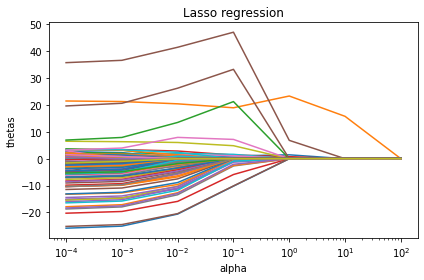

In [253]:
plt.plot(alpha, thetas)
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('thetas')
plt.title('Lasso regression')
plt.tight_layout()
#plt.savefig('figures/lasso_coefs.png',dpi=300)
plt.show()

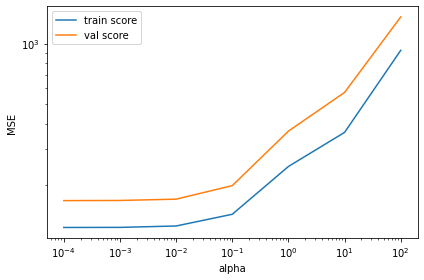

In [254]:
plt.plot(alpha,train_MSE,label='train score')
plt.plot(alpha,val_MSE,label='val score')
plt.semilogy()
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
#plt.savefig('figures/train_val_MSE_lasso.png',dpi=300)
plt.show()

#### Ridge (Regularization)

In [255]:
from  sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha = np.logspace(-10,0,51)

# arrays to save train and test MSE scores
train_MSE = np.zeros(len(alpha))
val_MSE = np.zeros(len(alpha))

thetas = []

# do the fit
for i in range(len(alpha)):
    # load the linear regression model
    lin_reg = Ridge(alpha=alpha[i])
    lin_reg.fit(df_train, y_train)
    thetas.append(lin_reg.coef_)
    # train and test scores
    train_MSE[i] = mean_squared_error(y_train,lin_reg.predict(df_train))
    val_MSE[i] = mean_squared_error(y_CV,lin_reg.predict(df_CV))

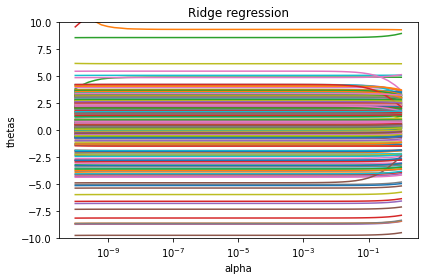

In [256]:
plt.plot(alpha, thetas) 
plt.semilogx()
plt.ylim([-1e1,1e1])
plt.xlabel('alpha')
plt.ylabel('thetas')
plt.title('Ridge regression')
plt.tight_layout()
#plt.savefig('figures/ridge_coefs.png',dpi=300)
plt.show()

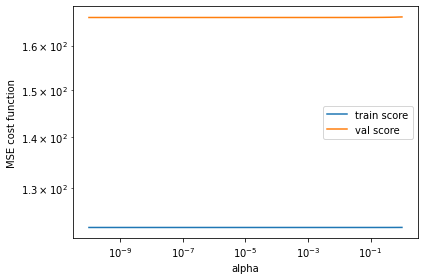

In [257]:
plt.plot(alpha,train_MSE,label='train score')
plt.plot(alpha,val_MSE,label='val score')
plt.semilogy()
plt.semilogx()
plt.xlabel('alpha')
plt.ylabel('MSE cost function')
plt.legend()
plt.tight_layout()
#plt.savefig('figures/train_val_MSE_ridge.png',dpi=300)
plt.show()

In [206]:
# Baseline: MSE = standard deviation of target column
print(y.std()) # baseline

# baseline-mean / std

28.00141465089365


In [241]:
# define function: used to get best values of 3 models chosen

from sklearn.model_selection import  TimeSeriesSplit

onehot_ftrs = ['Team','Year','Sport','Season']
std_ftrs = ['Population','Total_Athletes','Female_Athletes','Male_Athletes']

preprocessor = ColumnTransformer(transformers=[
            ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)])

def MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    
    final_models = []
    test_scores = []
    best_params = []
    best_models = []
    groups = medal_pop_contingent[['Team']] 
    
    # loop through 10 random states
    for i in [3,18,27,33,49,100,123,888,900,1000]:
    
        tscv = TimeSeriesSplit(n_splits = 3)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
            y_train, y_test = y[train_index], y[test_index]
            
        # preprocess the data 

        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
            pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', ML_algo)])
        
            grid = GridSearchCV(pipe, 
                            param_grid=param_grid,
                            scoring = make_scorer(mean_squared_error, 
                            greater_is_better=False, squared=False),
                            cv=tscv, return_train_score = True, 
                            n_jobs=-1, verbose=False)

            #print(X_train)
            grid.fit(X_train, y_train) #,groups=X_train[['Team']]) #??? train or test 
        
            results = pd.DataFrame(grid.cv_results_)
        
            # for each combination, calculate the train and validation scores using the evaluation metric  
            # find which hyperparameter combination gives the best validation score 
            # print('validation score:',grid.best_score_) # this is the mean validation score over all iterations

            # calculate the test score
            y_test_pred = grid.best_estimator_.predict(X_test)

            # append the test score 
            test_scores.append(mean_squared_error(y_test_pred,y_test, 
                            squared=False))

            # and the best model to the lists
            best_models.append(grid.best_estimator_)
        
            best_params.append(grid.best_params_)
            #print(best_params)
    return best_models, test_scores, best_params

In [242]:
# Set X and y
y = medal_pop_contingent['Medal_Won_Corrected']            
X = medal_pop_contingent.drop(["Medal_Won_Corrected"], axis=1)

In [245]:
# linear regression with l1 (10 mins)
ML_algo = Lasso()
param_grid = {'regressor__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

models, scores, params = MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid)
print(scores)
print("Mean is :", statistics.mean(scores))
print("Standard Deviation is : ", statistics.pstdev(scores))
print(params)

[12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681, 12.145016394705175, 9.03894454044407, 6.54006185210681]
Mean is : 9.241340929085352
Standard Deviation is :  2.29268431898067
[{'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'regressor__alpha': 0.01}, {'re

In [246]:
import pickle
file = open('../Lasso_Regression_Alpha1.save', 'wb')
pickle.dump((models),file)
file.close()

In [207]:
(28.00141465089365 - 9.241340929085352)/2.29268431898067

8.182580378160848

In [243]:
# linear regression with l2 regularization (11-12 mins)
from sklearn.linear_model import Ridge

ML_algo = Ridge()
param_grid = {'regressor__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

models, scores, params = MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid)
print(scores)
print("Mean is :", statistics.mean(scores))
print("Standard Deviation is : ", statistics.pstdev(scores))
print(params)

[12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984, 12.174717964501593, 9.009282867594896, 6.484280457016984]
Mean is : 9.222760429704492
Standard Deviation is :  2.3280104894938516
[{'regressor__alpha': 1.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 1.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 1.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 1.0}, {'regressor__alpha': 10.0}, {'regressor__alpha': 10.0}, {'regressor__a

In [244]:
import pickle
file = open('../Ridge_Regression_Alpha1.save', 'wb')
pickle.dump((models),file)
file.close()

In [208]:
(28.00141465089365 - 9.222760429704492)/2.3280104894938516

8.06639588005978

In [226]:
# k nearest neighbor regression (1+ hours)
from sklearn.neighbors import KNeighborsRegressor

ML_algo = KNeighborsRegressor()
param_grid = {'regressor__weights': ["uniform","distance"],
            'regressor__n_neighbors':[1,25,50,75,100]}

models, scores, params = MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid)
print(scores)
print("Mean is :", statistics.mean(scores))
print("Standard Deviation is : ", statistics.pstdev(scores))
print(params)

[2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179, 2.776574721846561, 1.1981103285173138, 0.773553039341179]
Mean is : 1.5827460299016844
Standard Deviation is :  0.8617743061967202
[{'regressor__n_neighbors': 1, 'regressor__weights': 'uniform'}, {'regressor__n_neighbors': 1, 'regressor__weights': 'uniform'}, {'regressor__n_neighbors': 1, 'regressor__weights': 'uniform'}, {'regressor__n_neighbors': 1, 'regressor__weights': 'uniform'}, {'regressor__n_neighbors': 1, 'regressor__weights': 'uniform'}, {'regressor__n_neighbors'

In [239]:
import pickle
file = open('../KNeighborsRegressor.save', 'wb')
pickle.dump((models),file)
file.close()

In [ ]:
(28.00141465089365 - 1.5827460299016844)/0.8617743061967202

In [ ]:
### Other models to try:
    
# # RF 
# from sklearn.ensemble import RandomForestRegressor 

# ML_algo = RandomForestRegressor()
# param_grid = {'regressor__max_depth': [1, 3, 10, 30, 100],
#             'regressor__max_features':[0.5,0.75,1.0]} #remove

# models, scores, params = MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid)
# print(scores)
# print("Mean is :", statistics.mean(scores))
# print("Standard Deviation is : ", statistics.pstdev(scores))
# print(params)

# # SVR

# ML_algo = SVR()
# param_grid = {'regressor__gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], 
#               "regressor__C":[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}

# models, scores, params = MLpipe_RMSE(X,y,preprocessor,ML_algo,param_grid)
# print(scores)
# print("Mean is :", statistics.mean(scores))
# print("Standard Deviation is : ", statistics.pstdev(scores))
# print(params)

### Notes about Methods

The standard deviation measures the average distance between the values of the dataset and the mean. Thus a low standard deviation indicates the numbers are close to the mean, whereas a high standard deviation indicates the points are more spread out. The algorithm on the dataset that performs best is the one with the lowest mean score.


## Global and/or local feature importances

In [216]:
# train the XGBoost model
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0])
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 0.013462992924948227
the test RMSE: 0.013894989184667295
the test R2: 0.9999998272500437


In [ ]:
#scatter plot of the true vs predicted values in regression
y_pred = XGB.predict(X_test)
print(y_pred)
print(y_test)
plt.plot(y_test,y_test,'k-', )
plt.scatter(y_test, y_pred) #predicting well? #x axis has true and y as pred
plt.savefig("../figures/ytrue_ypred_scatterplot.png", dpi = 300, bbox_inches='tight')
plt.show()

In [217]:
# code to fix bug in shap
import shap

mybooster = XGB.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
explainer = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


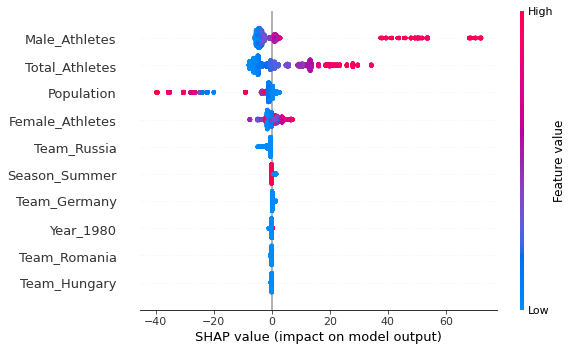

In [85]:
# feature importance breakdown (using groupshufflesplit)
shap_values = explainer.shap_values(df_test)

# Plot
shap.summary_plot(shap_values, df_test, max_display=10)


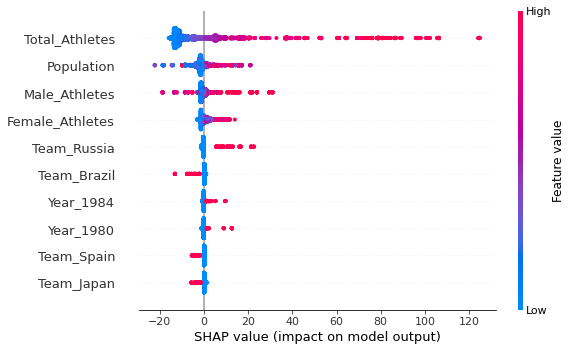

"\nAdditivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer \nis the same shape that the model was trained on. If your data shape is correct then please report \nthis on GitHub. Consider retrying with the feature_perturbation='interventional' option. This \ncheck failed because for one of the samples the sum of the SHAP values was 115.003067, while \nthe model output was 115.002090. If this difference is acceptable you can set check_additivity=False \nto disable this check.\n"

In [218]:
# feature importance breakdown (using timeseries)
shap_values = explainer.shap_values(df_test)

# Plot
shap.summary_plot(shap_values, df_test, max_display=10)


In [258]:
shap.initjs()
index = 0 # the index of the point to explain
shap.force_plot(explainer.expected_value, 
                shap_values[index,:],
                feature_names = feature_names[:-4])


In [220]:
shap.initjs()
index = 100 # the index of the point to explain
shap.force_plot(explainer.expected_value, 
                shap_values[index,:],
                feature_names = feature_names[:-4])

In [259]:
shap.initjs()
index = 200 # the index of the point to explain
shap.force_plot(explainer.expected_value, 
                shap_values[index,:],
                feature_names = feature_names[:-4])

## Discuss the results of model interpretations in the context of the problem

#### Which features are the most and least important? 
Total_Atheltes, Population, Male_Athletes, Female_athletes. Positive and negative impacts vary depending on index of point you are looking at.

#### Did you find something that’s unexpected/surprising/interesting?
feature can be positive for one index, negative for another. Can vary in size of arrow.

# Outlook 

There are always ways in which a model can be improved. More features and more data is always a good start. More features, such as gdp or athlete salaries, may help predict medal winning teams. As mentioned earlier, Chadha found that gdp and contingent size correlate. Further, athletes with higher salaries may be enticed to train harder and may have access to better equipment and funding. More data will likely help improve model performance. The more we know, the more knowledge we have that we can use to better predict. In this Olympic medal winning scenario, it may be helpful to have more data distinguishing countries. Beyond population, what do high medal winning countries have that countries with few wins don’t have? What do both countries have in common that must not affect how many medals a country wins? There are many questions and paths we can explore here.

As mentioned above, we combined all Russian teams to be one (same for Germany). This could have given Russia or Germany too many wins, thus affecting our model’s predictions. To improve the model, we may want to consider keeping all Russian and German teams separate and using data beyond population if we aren’t able to find a population split.

We could have used other techniques in our model as well. For instance adding more parameters to the models or increasing the parameter range may result in better parameters. We could have also increased the number of n_splits in the TimeSeriesSplit method. Further, we could have tested a different evaluation metric to see if results were better. 

Finally, we could have also explored other regression models such as random forest regressor.
Overall, models can always be improved and we must continue to check on them and update them over time to account for changes in the data or new information.

# Extra Notes

Original Dataset:
https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

The problem began as classification, predicting win (yes) or loss (no) per athlete. Here the target variable is winner, but the problem changed. We instead looked at number of medals won per team. Here the target varible is number of medals won, a regression problem. The original dataset was 271116 datapoints, 19 features.

The preprocessors chosen are based on what each features describes. For example, if it is categorical then it is a OneHotEncoder (no rank) or OrdinalEncoder (rank matters). If it is continuous then it is MinMaxEncoder (clear boundary) or StandardScaler (no clear boundary).

References:

Dataset: 120 years of Olympic history: athletes and results, Most recent update by rgriffin, (2018) 

(https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results)

Countries Population, most recent update by Alexander Shakhov (2017) 

(https://www.kaggle.com/centurion1986/countries-population)

Marco Giuseppe de Pinto, (2018) Let's discover more about the Olympic Games! 

(https://www.kaggle.com/marcogdepinto/let-s-discover-more-about-the-olympic-games)

Sagar Chadha, (2018) Olympics Data- Cleaning, Exploration, Prediction 

(https://www.kaggle.com/chadalee/olympics-data-cleaning-exploration-prediction)

Tomasz Klimek, (2018) Women of Olympic Games 

(https://www.kaggle.com/kl13mk/women-of-olympic-games)

Special shoutout to Chadha.

https://github.com/jillian-green/1030_Final_Project